In Yoon(2022), I follow accounting literature and percentile-based approach (winsorize at 1% and 99%) to address outliers. To test the robustness of the results...

### 2.1. Setup


In [76]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [77]:
# Import the dataset
sample_with_outliers = pd.read_csv('sample_detect_outliers.csv')

### 2.2. Conduct an Exploratory Data Analysis (EDA)

#### 2.2.1. Show the first 5 entries in the data

In [78]:
# First 5 entries
sample_with_outliers.head()

,identifier,lease,lag_lease,lag_market_value,lag_dividend,lag_loss,lag_cash,lag_tax_rate,lag_big4_auditor
0,1004,1.716172,1.300330,6.953107,0.007855,0,0.036106,0.362751,1
1,1004,1.664240,1.802926,6.736387,0.007212,0,0.021635,0.359671,1
2,1004,1.163486,1.595639,7.090351,0.006781,0,0.006848,0.354971,1
3,1004,1.416672,1.147767,7.346950,0.006755,0,0.027284,0.210000,1
4,1050,0.626734,0.659966,5.562565,0.013321,1,0.065985,0.350000,0


#### 2.2.2. The # of entries and the # of features
There are 6,279 entries.<br>
There are 9 variables = 1 identifier + 1 outcome variable + 7 firm features. The second variable shown above, lease, is the outcome variable.


In [79]:
# (Number of entries, Number of features)
print(sample_with_outliers.shape)

(6279, 9)


#### 2.2.3. Empirical distributions and histograms
There are many interesting observations that are worth noting. First, there are no missing values (all counts equal 6,279). I will explain others below.

In [80]:
# Show empirical distributions
sample_with_outliers.describe()

,identifier,lease,lag_lease,lag_market_value,lag_dividend,lag_loss,lag_cash,lag_tax_rate,lag_big4_auditor
count,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000,6279.000000
mean,57841.428094,1.951751,1.778861,7.625380,0.016864,0.236184,0.196037,0.255268,0.821628
std,66106.400906,3.091940,2.695251,1.731492,0.029755,0.424770,0.223529,0.117834,0.382856
min,1004.000000,0.000000,0.032784,3.607576,0.000000,0.000000,0.000571,0.000000,0.000000
25%,10221.000000,0.485310,0.452138,6.441416,0.000000,0.000000,0.038528,0.210000,1.000000
50%,24171.000000,0.919717,0.845846,7.535678,0.000000,0.000000,0.109758,0.338186,1.000000
75%,116166.000000,1.951153,1.801071,8.730227,0.022831,0.000000,0.262504,0.350000,1.000000
max,315318.000000,34.634146,15.867922,12.190620,0.203976,1.000000,0.960804,0.380506,1.000000


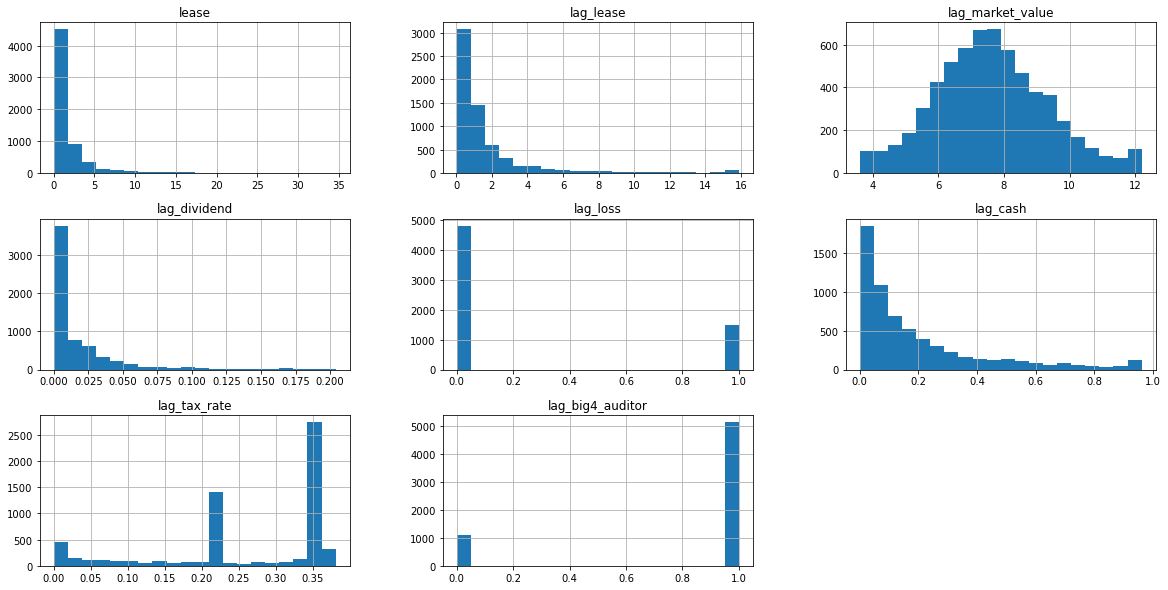

In [81]:
# Show histograms - all variables except for the identifier
sample_with_outliers.drop(columns='identifier').hist(bins = 20, figsize =(20, 10))
plt.show()

#### 2.2.4. Drop variables without outliers
The above two panels show that lag_loss and lag_big4_auditor are indicator variables without outliers. In addition, the histogram suggests that lag_tax_rate also does not have outliers. During the sample period (2016-2019), corporate tax rate was reduced from 35% to 21%. Two big spikes in the histogram around 35% and 21% and all other values smaller than 35% make an economic sense.

Therefore, I will create a new dataframe with variables that have outliers.

In [82]:
# Drop identifier, lag_loss, lag_big4_auditor, and lag_tax_rate 
sample = sample_with_outliers.drop(columns=['identifier', 'lag_loss', 'lag_big4_auditor', 'lag_tax_rate'])

### 2.3. Z-Score - Detect and Remove Outliers
For data that follow a gaussian distribution, the Z-Score method is effective in addressing outliers.

The z-score indicates the distance of a data point from the mean as the number of standard deviations. The formula is as follows:

![Introduction](https://github.com/youngdataspace/treat-outliers/blob/main/Z%20Score.JPG?raw=true)


I am going to assume that observations with a Z-score below -2.5 or above 2.5 (i.e., 2.5 standard deviations away from the mean; 1% of the sample) are outliers.

#### 2.3.1. lag_market_value - Identify and remove outliers
The previous figure shows that lag_market_value follows a gaussian distribution. I will first calculate the outlier thresholds.

In [83]:
# Find the boundary values
print("Highest allowed",sample['lag_market_value'].mean() + 3*sample['lag_market_value'].std())
print("Lowest allowed",sample['lag_market_value'].mean() - 3*sample['lag_market_value'].std())

Highest allowed 12.81985531974234
Lowest allowed 2.4309039513109827


It turns out that all of the values (N=6,279) are within the boundary values of 2.43 and 12.81. Thus, none of the observations are trimmed.

In [84]:
# Filter outliers
sample = sample[(sample['lag_market_value'] >= 2.43) | (sample['lag_market_value'] <= 12.82)]
print(sample.shape)

(6279, 5)


I'll drop lag_market_value because no outlier treatment is necessary.

In [85]:
# Drop lag_market_value
sample = sample.drop(columns=['lag_market_value'])

#### 2.3.2. Log transformation of other variables
The histogram above shows that lease, lag_lease, lag_dividend, and lag_cash are all significantly right skewed. The Z-Score method or many other popular outlier detection methods such as the Interquartile Range (IQR) method won't do any good. To address this issue, I will conduct log transformations on these variables to see if I can describe them with normal distribution.

The histogram also shows that the four variables have many zeros (or very small values), which make economic sense. Therefore, I will only look for outliers on the right-hand side of the distribution. 

First, I will replace zeros with NaNs. This is okay because zeros will not be considered outliers.

In [86]:
# Replace zeros with NaNs
sample['lag_dividend'] = sample['lag_dividend'].replace([0],np.NaN)
sample['lease'] = sample['lease'].replace([0],np.NaN)

Next, I perform the log transformations and plot histograms

In [87]:
# Create a function to conduct log transformation
def log_transformation_function (dataframe, column_name):
    """ Conduct a log transformation of a variable """
    # Replace the values with log-transformed values
    dataframe[[column_name]] = dataframe[[column_name]].apply(np.log)

# Conduct log transformation on all the variables
for column in sample:
    log_transformation_function(sample, column)   

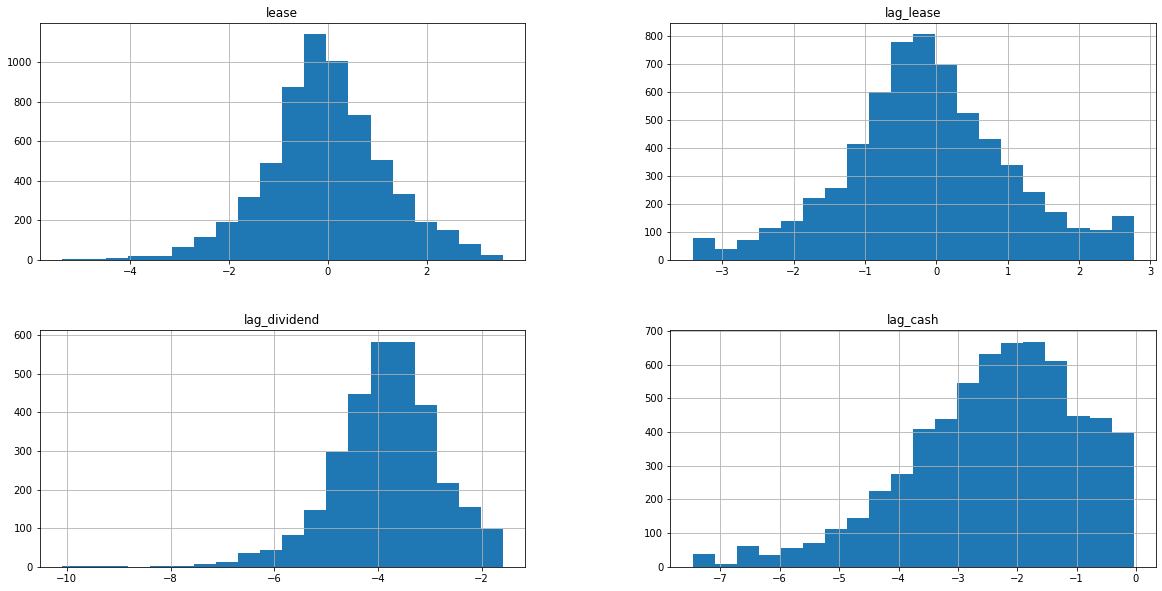

In [88]:
# Plot histrograms
sample.hist(bins = 20, figsize =(20, 10))
plt.show()

#### 2.3.3. Other variables - Identify and remove outliers
The distibutions now look much more like normal distributions. Once again, I will use the Z-Score to identify outliers.

First, I report the Z-Score upper limits for each variable.

In [89]:
# Create a function to repot the upper limit of the Z-Score
def print_upper_limit (dataframe, column_name):
    """ Print the upper limit of the Z-score """
    
    # Compute the upper limit
    upper_limit = dataframe[column_name].mean() + 3 * dataframe[column_name].std()
    
    # Round and return the limit
    upper_limit = round(upper_limit, 2)
    return(upper_limit)

# Print the upper limit for each variable
print("UPPER LIMITS")
for column in sample:
    print(f"{column}: {print_upper_limit(sample, column)}")

UPPER LIMITS
lease: 3.55
lag_lease: 3.42
lag_dividend: -0.8
lag_cash: 1.97


Next, I repot the maximum values of each variable.

In [90]:
# Print the maximum values
print("")
print("MAXIMUM VALUES")
print(round(sample.max(),2))   


MAXIMUM VALUES
lease           3.54
lag_lease       2.76
lag_dividend   -1.59
lag_cash       -0.04
dtype: float64


All of the maximum values are smaller than the upper limits. Thus, none of them seems to have outliers.